# Load modules

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tsfel
import sklearn
from sklearn.decomposition import PCA
from sklearn.ensemble import StackingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statistics
import seaborn as sn
from rulefit import RuleFit
from sklearn.model_selection import train_test_split


# Load data

In [ ]:
data = np.load(os.path.join('data', 'raw_feature_extracted', 'raw_feature_extracted_dataset_1.npz'),
                allow_pickle=True)
datasets = data['feature_extracted_dataset'].tolist()

# training dataset
x_train = pd.concat([datasets.get('ECG_features')[0], datasets.get('GSR_features')[0]], axis=1)
y_train = data['y_train']

# test dataset
x_test = pd.concat([datasets.get('ECG_features')[1], datasets.get('GSR_features')[1]], axis=1)


# Features analysis

In [ ]:
## preprocess

repeated_feats = []
# check of repetitive values in features
for col in x_train.columns:
    counts = x_train[col].value_counts()
    max = (counts.max() / x_train.shape[0]) * 100
    if max > 50:
        repeated_feats.append(col)
print(repeated_feats)

#x_train.drop(to_drop, inplace=True, axis=1)
#x_test.drop(to_drop, inplace=True, axis=1)

(array([  0.5,  12.5,  24.5,  36.5,  48.5,  60.5,  72.5,  84.5,  96.5,
        108.5, 120.5, 132.5, 144.5, 156.5, 168.5, 180.5, 192.5, 204.5,
        216.5, 228.5, 240.5, 252.5, 264.5, 276.5, 288.5]),
 [Text(0.5, 0, 'ECG_features_handcrafted0_0_ECDF Percentile Count_0'),
  Text(12.5, 0, 'ECG_features_handcrafted0_0_Skewness'),
  Text(24.5, 0, 'ECG_features_handcrafted1_0_Max'),
  Text(36.5, 0, 'ECG_features_handcrafted2_0_Histogram_8'),
  Text(48.5, 0, 'ECG_features_handcrafted3_0_ECDF_0'),
  Text(60.5, 0, 'ECG_features_handcrafted4_0_ECDF Percentile Count_0'),
  Text(72.5, 0, 'ECG_features_handcrafted4_0_Skewness'),
  Text(84.5, 0, 'ECG_features_handcrafted5_0_Kurtosis'),
  Text(96.5, 0, 'ECG_features_handcrafted6_0_Histogram_7'),
  Text(108.5, 0, 'ECG_features_handcrafted7_0_ECDF Percentile_1'),
  Text(120.5, 0, 'ECG_features_handcrafted7_0_Variance'),
  Text(132.5, 0, 'GSR_features_handcrafted0_0_Median absolute deviation'),
  Text(144.5, 0, 'GSR_features_handcrafted1_0_Kurtosis'),


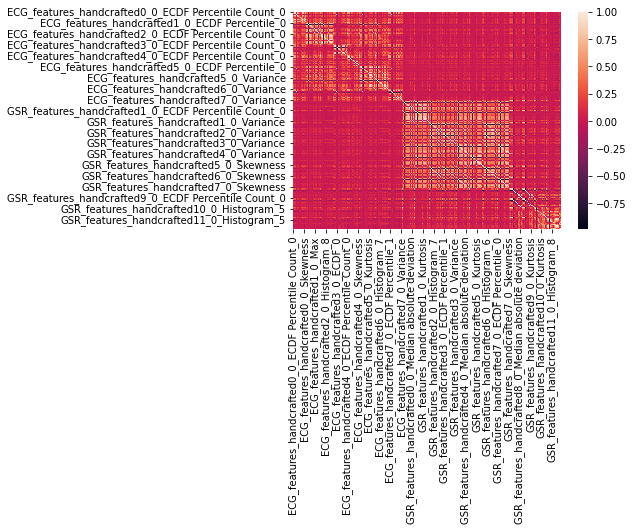

In [11]:
## correlation
corr_matrix = x_train.corr()
sn.heatmap(corr_matrix)
plt.yticks(rotation=0)
plt.xticks(rotation=90)


# commonly used correlation filtering methods have a tendency to unnecessarily drop features. 

# Data scaling 

In [7]:
newcolumns = x_train.columns

# Normalising Features
scaler = StandardScaler()
scaler.fit(x_train)
train_features = scaler.transform(x_train)
train_features = pd.DataFrame(data=train_features, columns=newcolumns, index=np.arange(0, x_train.shape[0]))

test_features = scaler.transform(x_test)
test_features = pd.DataFrame(data=test_features, columns=newcolumns, index=np.arange(0, x_test.shape[0]))



# Model building

## Logistic Regression with Recursive Feature Elimination (RFE)

In [ ]:
# model 0 logistic with stepwise 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(estimator = logreg, n_features_to_select = 5)
rfe = rfe.fit(train_features, y_train)

yhat_logit = rfe.predict(test_features)
#np.savetxt('answer.txt', yhat.astype(int), delimiter='', fmt='%.0f')


## Support Vector Machine with RFE and parameter tuning (Grid search)

In [8]:

# model 1 svm with rfe
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

rfe = RFE(estimator=SVC(kernel='linear'), n_features_to_select=5)
param_grid = {"C": [0.1,1, 10, 100, 1000]} #[0.1, 0.5, 1, 1.5, 2, 5 ,10, 100, 1000]}  # [1,0.1,0.01,0.001]
search = GridSearchCV(estimator=SVC(kernel='linear'), param_grid=param_grid, n_jobs=4, verbose=True, cv=5,
                      scoring='accuracy')
pipeline = Pipeline(steps=[('s', rfe), ('rs', search)])
# pipeline.fit(train_features, training_labels)
pipeline.fit(train_features, y_train)

print(search.best_estimator_)

yhat = pipeline.predict(test_features)
np.savetxt('answer.txt', yhat.astype(int), delimiter='', fmt='%.0f')




Fitting 2 folds for each of 5 candidates, totalling 10 fits
SVC(C=1, kernel='linear')
